# EuroPi calibration

The calibration or the EuroPi analog input and analog outputs is quite simple.

To calibrate the input, we apply a reference voltage to the analog input and measure the ADC (Analog to Digial Converter) output. We repeat this process several times with different reference voltages spanning the whole analog input range. To get the ADC reading corresponding to other voltages, we simply interpolate the value with a linear approximation.

Calibrating the CV outputs requires a bit more work as the Raspberry Pi Pico does not have a
DAC (Digital to Analog Converter). The outputs are PWM (Pulse-Width Modulation) oscillators. A low-pass filter is
used to smooth out the rapid switching of the PWM to create a stable voltage.  To generate a specific voltage, we
vary the duty-cycle of the PWM oscillator.

To calibrate the analog output, we select a reference voltage and adjust the duty-cycle until the reference
voltage is measured at the output using a precise voltmeter. We repeat this process with different reference
voltages spanning the entire analog output range and, like for the analog input, we use linear interpolation
to determine the duty-cycle for other voltages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

MAX_UINT16 = 65535

MIN_INPUT_VOLTAGE = 0
MAX_INPUT_VOLTAGE = 12

MIN_OUTPUT_VOLTAGE = 0
MAX_OUTPUT_VOLTAGE = 10

def clamp(value, low, high):
    return max(min(value, high), low)

# just an utility function
def create_plot(x_min=0, x_max=10, ticks=1):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(x_min, x_max+1, ticks)
    ax.set_xticks(major_ticks)
    ax.grid(which='both')
    ax.set_axisbelow(True)
    return ax

# Analog Input (ain) calibration procedure

The **reference voltages** used for the calibration are :

In [2]:
# reference voltages :
INPUT_CALIBRATION_POINTS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

To **read the ADC output** we use the function :

`ADC_reading = ain.read_u16()`

For a single reading, we call `read_u16()` several time and use the average value as the reading value. This allow to smooth-out the inherent ADC noise.

In [3]:
def sample():
    readings = []
    for reading in range(256):
        readings.append(ain.read_u16())
    return round(sum(readings) / 256)

Once we have measured the different reference voltages defined above, we get a serie of corresponding ADC readings : 

In [4]:
# ADC readings :
INPUT_CALIBRATION_VALUES = [523, 3950, 7396, 11242, 15464, 19698, 24520, 29801, 34257, 38762, 44268]

We can represent these calibration points on a graph :

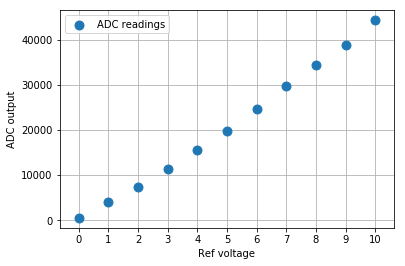

In [5]:
ax = create_plot()
p = ax.scatter(INPUT_CALIBRATION_POINTS, INPUT_CALIBRATION_VALUES, s=80)
p.set_label('ADC readings')
ax.legend()
plt.xlabel('Ref voltage')    # reference voltages as X
plt.ylabel('ADC output')     # ADC readings as Y
plt.show()

### Saving of the calibration results :

Once all the references voltage have been applied and the ADC readings done, these values are saved in the `calibration.py` file. This file will be loaded by the firmware and the values used to correct the ADC readings when calling `europi.voltage()` for example.

## Usage of the calibration values in the firmware :

Each pair or calibration point is connected with a linear segment of the form :

**y = m*x + b**

- `m` is the gradient (or slope)
- `b` is the `y` offset at the origin of the segment.

The gradient is calculated with `gradient = (y1-y0) / (x1-x0)`

In our case the `y` values are the ADC readings, and the `x` values are the reference voltages used for the calibration.

#### We can represent these segments in a graph : 

_Please note that the axis have been swapped, X is now the ADC readings._

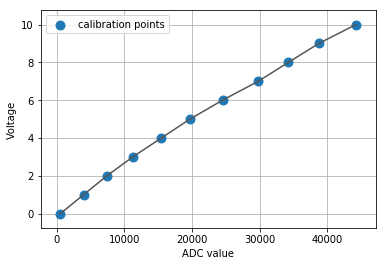

In [6]:
ax = create_plot(0, 65535, 10000)
p1, = ax.plot(INPUT_CALIBRATION_VALUES, INPUT_CALIBRATION_POINTS, '#555555')
p2 = ax.scatter(INPUT_CALIBRATION_VALUES, INPUT_CALIBRATION_POINTS, s=80)
p2.set_label('calibration points')
ax.legend()
plt.xlabel('ADC value')
plt.ylabel('Voltage')
plt.show()

### Gradients precomputation :

We can precompute these segments' gradients in advance. This will allow for a slightly faster correction computation when we read a voltage :

In [7]:
gradients = []
for index, value in enumerate(INPUT_CALIBRATION_VALUES[:-1]):
    gradients.append(
        (INPUT_CALIBRATION_POINTS[index + 1] - INPUT_CALIBRATION_POINTS[index]) /
        (INPUT_CALIBRATION_VALUES[index + 1] - value))

We re-use the last gradient for the ADC values that exceed the last calibration point :

In [8]:
gradients.append(gradients[-1])

In [9]:
print("gradients :", ', '.join(f"{g:0.6f}" for g in gradients))

gradients : 0.000292, 0.000290, 0.000260, 0.000237, 0.000236, 0.000207, 0.000189, 0.000224, 0.000222, 0.000182, 0.000182


### How is the calibration applied : 

We want to know the voltage that correspond to the following ADC reading :

In [10]:
reading = 25000

**Begin by finding the first segment that includes our reading :**

In [11]:
index = next(index for index, r in enumerate(INPUT_CALIBRATION_VALUES) if r >= reading) - 1

print(f"index = {index} (segment {INPUT_CALIBRATION_VALUES[index]}..{INPUT_CALIBRATION_VALUES[index+1]})")

index = 6 (segment 24520..29801)


**Then, calculate the corresponding value (voltage) with the linear equation formula :**

**`y = offset + (slope * x)`**

In the above formula, `offset` is the y value at `x=0` (origin).

In our case, the origin point is (`INPUT_CALIBRATION_POINTS[index]`, `INPUT_CALIBRATION_VALUES[index]`)

We already have `slope` value, this is the segment's gradient we precomputed before.

We have a special case if the reading is lower then the lowest calibration reading, in this case `index=-1` and we simply say that the voltage is 0 (since we do not go into negative voltage).

In [12]:
if index < 0:
    cv = 0
    print(f"cv = 0 V for ADC reading = {reading}")
else:
    cv = INPUT_CALIBRATION_POINTS[index] + gradients[index] * (reading - INPUT_CALIBRATION_VALUES[index])
    print(f"cv = {INPUT_CALIBRATION_POINTS[index]} + {gradients[index]:0.6f} * ({reading}-{INPUT_CALIBRATION_VALUES[index]}) = {cv:0.2f} V for ADC reading = {reading}")    

cv = 6 + 0.000189 * (25000-24520) = 6.09 V for ADC reading = 25000


# Outputs calibration :

We use the analog input (_ain_) to calibrate the analog outputs. We use _ain_ to measure the output voltage. It is therefore important that the analog input has been calibrated beforehand.

For this, we need to know what is the ADC value that coresponds to a given voltage.

### How to calculate the analog input ADC value for a specific voltage :

This is very similar to the previous computations used to get the real voltage from an ADC reading. We use the same precomputed gradients as before but, instead of finding the voltage from and ADC value, we want to get the ADC value for a given voltage.

Let's say we want to calibrate our output to generate 5.00 V :

In [13]:
cv = 5.00

Since we use _ain_ to measure the output, we must therefore determine what is the ADC value which corresponds to a value of 5V at _ain_.

**Find the first segment that includes the given voltage :**

In [14]:
index = next(index for index, v in enumerate(INPUT_CALIBRATION_POINTS) if v >= cv) - 1

print(f"index = {index} (segment {INPUT_CALIBRATION_POINTS[index]}..{INPUT_CALIBRATION_POINTS[index+1]})")

index = 4 (segment 4..5)


**Calculate the corresponding value (ADC reading) with the linear equation formula :**

In [15]:
if index < 0:
    expected_reading = INPUT_CALIBRATION_VALUES[0]
else:    
    expected_reading = int(INPUT_CALIBRATION_VALUES[index] + (cv - INPUT_CALIBRATION_POINTS[index]) / gradients[index])
    
print(f"ADC value must be {expected_reading} for ain = {cv} V")

ADC value must be 19698 for ain = 5.0 V


## Calibration of the output :

To output a voltage we use the following function :

`pin.duty_u16(N)`
    
`N` is a 16 bits number (0..65535).

### The calibration process is simple : 

We set the output duty_cycle to generate a voltage, measure it with _ain_ and compare against a reference _ain_ reading. We adjust the output voltage until the _ain_ reading matches the reference value.

1. generate a voltage with a duty_cycle N
2. measure this voltage with ain ADC
3. correct the output voltage duty_cycle (N) and try again until the ain reading matches the reference value

**We do this for every 1V from 0 to 10V.**

_Implementation note: since we calibrate for 1, 2, 3 ... 10V, we can directly use the reference output voltage as the index of the output calibration list._

The results above, saved in `output_duties` are the reference values for the output calibration.

We write these values as **`OUTPUT_CALIBRATION_VALUES`** :

In [16]:
OUTPUT_CALIBRATION_VALUES=[0, 4870, 9820, 15530, 21630, 27810, 34640, 41640, 48630, 55770, 63090]

Since we used a `range(0, 11)` for the calibration points, we have :

In [17]:
OUTPUT_CALIBRATION_POINTS=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

## Use the output calibration data to generate a precise voltage : 

Optimisation note : with the above definition we always have `OUTPUT_CALIBRATION_POINTS[index] == index` 
when we `enumerate(OUTPUT_CALIBRATION_POINTS)`. We can therefore replace `OUTPUT_CALIBRATION_POINTS[index]` with `index` and `OUTPUT_CALIBRATION_POINTS[index+1]` with `index+1`.

Again, the usage is very similar to the one applied to the input calibration data. We connect the output calibration values with linear segments and use the simple linear equation to interpolate the values.

### Output gradients precomputation :

In [18]:
out_gradients = []
for index, value in enumerate(OUTPUT_CALIBRATION_VALUES[:-1]):
    out_gradients.append(
        (index + 1 - index) /
        (OUTPUT_CALIBRATION_VALUES[index + 1] - value))
out_gradients.append(out_gradients[-1])

print("out_gradients :", ', '.join(f"{g:0.6f}" for g in out_gradients))

out_gradients : 0.000205, 0.000202, 0.000175, 0.000164, 0.000162, 0.000146, 0.000143, 0.000143, 0.000140, 0.000137, 0.000137


### Usage of the calibration to get the output PWN duty cycle value :

In [19]:
voltage = 2.50
index, decimal = (int(voltage // 1), voltage % 1)
dac = int(OUTPUT_CALIBRATION_VALUES[index] + (decimal / out_gradients[index]))

print(f"index = {index}")
print(f"duty_cycle = int({OUTPUT_CALIBRATION_VALUES[index]} + ({voltage % 1} / {out_gradients[index]:0.6f})) = {dac}")

index = 2
duty_cycle = int(9820 + (0.5 / 0.000175)) = 12675


### Optimisations :

We can simplify the `out_gradients` precomputation with 

`(index + 1 - index) == 1`

and, if we don't do the `1 / (...)` division :

In [20]:
out_gradients = []
for index, value in enumerate(OUTPUT_CALIBRATION_VALUES[:-1]):
    out_gradients.append(OUTPUT_CALIBRATION_VALUES[index + 1] - value)
out_gradients.append(out_gradients[-1])

the output duty cycle computation becomes :

In [21]:
duty_cycle = int(OUTPUT_CALIBRATION_VALUES[index] + (decimal * out_gradients[index]))

# Tests

Some quick tests to verify the above processes do not generate invalid values.

### Input 

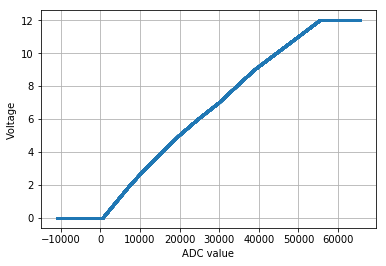

In [22]:
def read_voltage(reading):
    try:
        index = next(index for index, v in enumerate(INPUT_CALIBRATION_VALUES) if v >= reading) - 1
    except StopIteration:
        index = len(INPUT_CALIBRATION_VALUES) - 1
    if index < 0:
        cv = 0
    else:
        cv = INPUT_CALIBRATION_POINTS[index] + gradients[index] * (reading - INPUT_CALIBRATION_VALUES[index])
    return clamp(cv, MIN_INPUT_VOLTAGE, MAX_INPUT_VOLTAGE)

x = range(-11000, 65536, 5)
y = list(read_voltage(r) for r in x)
ax = create_plot(-10000, 65535, 10000)
ax.scatter(x, y, s=2)
plt.xlabel('ADC value')
plt.ylabel('Voltage')
plt.show()

_Note: negative ADC value have no meaning; it's just for testing that the formula can accept any value._

### Output

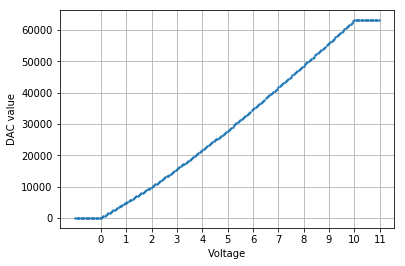

In [23]:
OUTPUT_CALIBRATION_VALUES=[0, 4870, 9820, 15530, 21630, 27810, 34640, 41640, 48630, 55770, 63090]

def dac(voltage):
    voltage = clamp(voltage, MIN_OUTPUT_VOLTAGE, MAX_OUTPUT_VOLTAGE)
    index, decimal = (int(voltage // 1), voltage % 1)
    return clamp(int(OUTPUT_CALIBRATION_VALUES[index] + (decimal * out_gradients[index])), 0, MAX_UINT16)

## If we want to accept any positive voltage : 
# def dac(voltage):
#     index, decimal = (int(voltage // 1), voltage % 1)
#     if index >= len(OUTPUT_CALIBRATION_VALUES):        
#         offset = OUTPUT_CALIBRATION_VALUES[-1]
#         gradient = out_gradients[-1]
#         decimal = decimal + (index - len(OUTPUT_CALIBRATION_VALUES) + 1)
#     else:
#         offset = OUTPUT_CALIBRATION_VALUES[index]
#         gradient = out_gradients[index]
#     return clamp(int(offset + (decimal / gradient)), 0, MAX_UINT16)
    
x = np.arange(-1, 11, 0.05)
y = list(dac(v) for v in x)
ax = create_plot(x_max=12)
ax.scatter(x, y, s=2)
plt.xlabel('Voltage')
plt.ylabel('Duty cycle value')
plt.show()